In [1]:
import math, pickle, collections
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
./experiments/scripts/rfcn_end2end_ohem.sh 0 ResNet-101 pascal_voc &

In [38]:
%run ./tools/test_net.py --gpu 0 --def models/pascal_voc/ResNet-101/rfcn_end2end/test_agnostic.prototxt --net /home/ubuntu/py-R-FCN/output/rfcn_end2end_ohem/voc_2007_trainval/resnet101_rfcn_ohem_iter_20000.caffemodel --imdb voc_2007_test --cfg experiments/cfgs/rfcn_end2end_ohem.yml



Called with args:
Namespace(caffemodel='/home/ubuntu/py-R-FCN/output/rfcn_end2end_ohem/voc_2007_trainval/resnet101_rfcn_ohem_iter_20000.caffemodel', cfg_file='experiments/cfgs/rfcn_end2end_ohem.yml', comp_mode=False, gpu_id=0, imdb_name='voc_2007_test', max_per_image=400, prototxt='models/pascal_voc/ResNet-101/rfcn_end2end/test_agnostic.prototxt', rpn_file=None, set_cfgs=None, vis=False, wait=True)
Using config:
{'DATA_DIR': '/home/ubuntu/py-R-FCN/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'rfcn_end2end_ohem',
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/ubuntu/py-R-FCN/models/pascal_voc',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/ubuntu/py-R-FCN',
 'TEST': {'AGNOSTIC': True,
          'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_

In [2]:
%run ./tools/test_net.py --gpu 0 --def models/pascal_voc/ResNet-101/rfcn_end2end/test_agnostic.prototxt --net /home/ubuntu/py-R-FCN/output/rfcn_end2end_ohem/voc_2007_trainval/resnet101_rfcn_ohem_iter_30000.caffemodel --imdb voc_2007_test --cfg experiments/cfgs/rfcn_end2end_ohem.yml



Called with args:
Namespace(caffemodel='/home/ubuntu/py-R-FCN/output/rfcn_end2end_ohem/voc_2007_trainval/resnet101_rfcn_ohem_iter_30000.caffemodel', cfg_file='experiments/cfgs/rfcn_end2end_ohem.yml', comp_mode=False, gpu_id=0, imdb_name='voc_2007_test', max_per_image=400, prototxt='models/pascal_voc/ResNet-101/rfcn_end2end/test_agnostic.prototxt', rpn_file=None, set_cfgs=None, vis=False, wait=True)
Using config:
{'DATA_DIR': '/home/ubuntu/py-R-FCN/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'rfcn_end2end_ohem',
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/ubuntu/py-R-FCN/models/pascal_voc',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/ubuntu/py-R-FCN',
 'TEST': {'AGNOSTIC': True,
          'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_

In [44]:
#training loss visualization
history = {'loss':[], 'accuracy':[], 'loss_bbox':[], 'loss_cls':[], 'rpn_cls_loss':[], 'rpn_loss_bbox':[] }
f = open('experiments/logs/rfcn_end2end_ResNet-101_.txt.2017-02-24_05-44-33','r')  
for line in f.readlines():
    if "Iteration" in line and "loss" in line:
        history['loss'].append(line.split('=')[-1][1:-1])
    if "Train net output #0" in line:
        history['accuracy'].append(line.split('=')[-1][1:-1]) 
    if "Train net output #1" in line:
        history['loss_bbox'].append(line.split('=')[-1][1:-7])
    if "Train net output #2" in line:
        history['loss_cls'].append(line.split('=')[-1][1:-7]) 
    if "Train net output #3" in line:
        history['rpn_cls_loss'].append(line.split('=')[-1][1:-7]) 
    if "Train net output #4" in line:
        history['rpn_loss_bbox'].append(line.split('=')[-1][1:-7]) 
f.close()                  

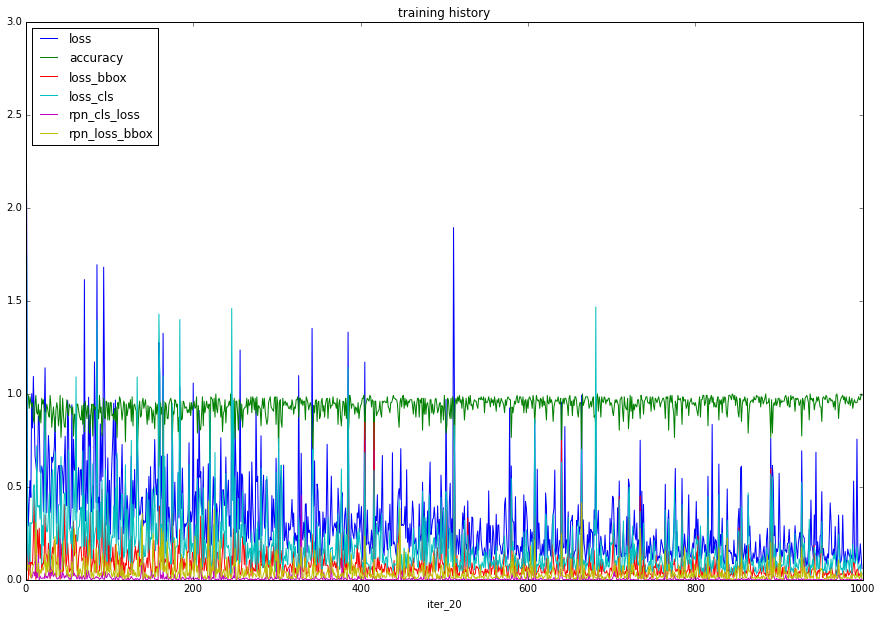

In [45]:
# summarize history for accuracy
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 10))
plt.plot(history['loss'][:1000]);
plt.plot(history['accuracy'][:1000]);
plt.plot(history['loss_bbox'][:1000]);
plt.plot(history['loss_cls'][:1000]);
plt.plot(history['rpn_cls_loss'][:1000]);
plt.plot(history['rpn_loss_bbox'][:1000]);
plt.title('training history'); 
plt.xlabel('iter_20');
plt.legend(['loss', 'accuracy', 'loss_bbox', 'loss_cls', 'rpn_cls_loss', 'rpn_loss_bbox'], loc='upper left');
plt.show()

In [19]:
with open('output/rfcn_end2end_ohem/voc_2007_test/resnet101_rfcn_ohem_iter_30000/detections_full_AGNOSTICnms_resnet101_rfcn_ohem_iter_30000_stg12.pkl','rb') as f:
    detections_stg12 = pickle.load(f) 

In [54]:
detections_stg12[-4778].shape

(61, 12)

In [ ]:
count = [len(detections[i]) for i in range(len(detections))]
collections.Counter(count)

In [22]:
with open('output/rfcn_end2end_ohem/voc_2007_test/resnet101_rfcn_ohem_iter_30000/detections_full_AGNOSTICnms_resnet101_rfcn_ohem_iter_30000.pkl','rb') as f:
    detections_stg1 = pickle.load(f) 

In [55]:
detections_stg1[-4778].shape

IndexError: list index out of range

In [33]:
len(detections_stg1)

4777